# LASSO regression using grid search CV 
The following code is highly inspired by "https://github.com/fnauman/timeseries/blob/master/candydata/xgboost_pipeline_candy.ipynb" but modified to fit our data. The times series handling and use of TimeSeriesSplit is confirmed by https://github.com/carl24k/fight-churn


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, learning_curve, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.metrics import make_scorer


In [2]:
# Defining different measures to evaluate performance 
# MAPE
def mean_absolute_percentage_error(y_true, y_pred, eps = 1e-8): 
    return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100 

mape = make_scorer(mean_absolute_percentage_error, 
                   greater_is_better=False)

# SMAPE
def symmetric_mape(y_true, y_pred, eps = 1e-8):
    summ = ((np.abs(y_true) + np.abs(y_pred)) + eps)
    return np.mean(np.abs(y_pred - y_true) / summ) * 100

smape = make_scorer(symmetric_mape, 
                    greater_is_better=False)

def print_scores(y_test, y_pred):
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"MSE score: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE score: {mean_absolute_error(y_test, y_pred)}")
    print(f"Median AE score: {median_absolute_error(y_test, y_pred)}")
    print(f"MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}")
    print(f"SMAPE score: {symmetric_mape(y_test, y_pred)}")

In [23]:
# Load in the time series
candy = pd.read_csv('dfV3.csv')
# Set the index equal to time stamp
candy["Unnamed: 0"] = pd.to_datetime(candy["Unnamed: 0"])
candy = candy.set_index('Unnamed: 0')


In [24]:
# Split the data into a train and test set
df_train, df_test = candy.iloc[:-9341], candy.iloc[-9341:]

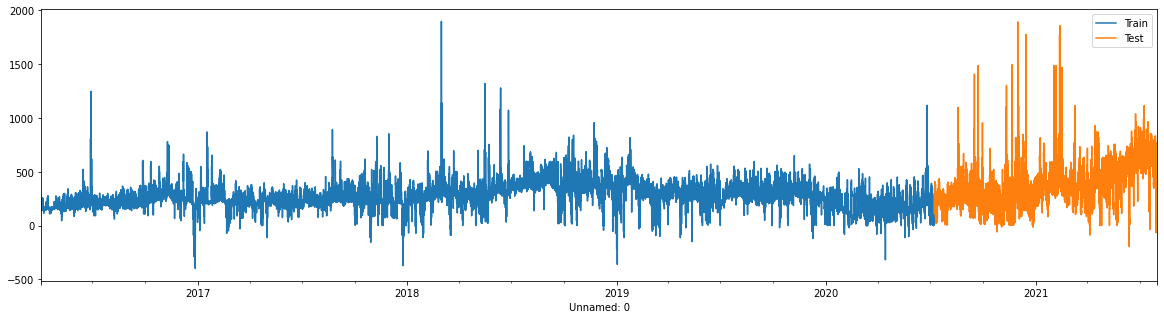

In [32]:
# Create plot visualizing the train and test data 

# Create an axis
fig, ax = plt.subplots(figsize = (20,5))

# Plot the train and test setsa dn show
df_train["DK2"].plot(ax=ax)
df_test["DK2"].plot(ax=ax)
#plt.axvline(x=4000, color='k', linestyle='--')
ax.legend(["Train", "Test"]);
plt.show()

In [5]:
# Create arrays for X and y for both training and testing data set. 
y_train = df_train[["DK2"]].to_numpy()
y_test  = df_test[["DK2"]].to_numpy()

X_train = df_train.copy()
X_test  = df_test.copy()

X_train.drop('DK2', inplace=True, axis=1)
X_test.drop('DK2', inplace=True, axis=1)

X_train = X_train.to_numpy()
X_test  = X_test.to_numpy()

In [28]:
# Define the pipeline for the Lasso regression
pipe_lasso = Pipeline([
                       #('polynomial', PolynomialFeatures(degree = 2, include_bias=True, interaction_only=True)),
                       ('scale', StandardScaler()),
                       ('lasso', Lasso())
                       ])

# Set the different values of lambdas to be searched through in the CV
params_lasso = {'lasso__alpha': np.logspace(-4,4,20)}

In [27]:
# Define the type of cross validation used in the grid search. The TimesSeriesSplit 
# is the k-fold alternative for times series keeping the natural order in the data 
# i.e. one avoid using future observations to predict the past. 
ts_cv = TimeSeriesSplit(n_splits=20).split(X_train_new)

# Define the pipeline for the grid search using the LASSO pipeline and defined type of CV.
# Further, we apply the relevant scoring and parallelizes the CV
gs_lasso = GridSearchCV(pipe_lasso,
                        param_grid=params_lasso,
                        scoring='neg_mean_absolute_error',
                        cv=ts_cv,
                        n_jobs=4)

In [35]:
ts_cv = TimeSeriesSplit(n_splits=20).split(X_train)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lasso,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_absolute_error',                 
                   cv=ts_cv)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))

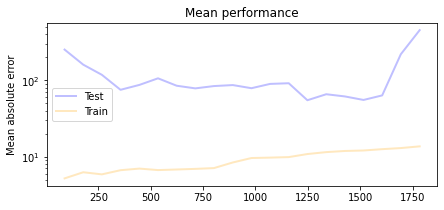

In [36]:
f_learn, ax = plt.subplots(figsize=(7,3))
ax.plot(train_sizes,-test_scores.mean(1), alpha=0.25, linewidth=2, label ='Test', color='blue') # negated, because we already use neg_MSE
ax.plot(train_sizes,-train_scores.mean(1), alpha=0.25, linewidth=2, label='Train', color='orange') # negated, because we already use neg_MSE

ax.set_title('Mean performance')
ax.set_ylabel('Mean absolute error')
ax.set_yscale('log')
ax.legend()

In [39]:
from sklearn.model_selection import validation_curve
ts_cv = TimeSeriesSplit(n_splits=20).split(X_train)

# FIT AND EVALUATE FOR DIFFERENT LAMBDAS
train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_train,
                     y=y_train,
                     param_name='lasso__alpha',
                     param_range=np.logspace(-4,4,20),
                     scoring='neg_mean_absolute_error',                 
                     cv=ts_cv,
                     n_jobs = 4)

# OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST
mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':np.logspace(-4,4,20)})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

lambda
0.615848    42.495233
Name: Validation, dtype: float64


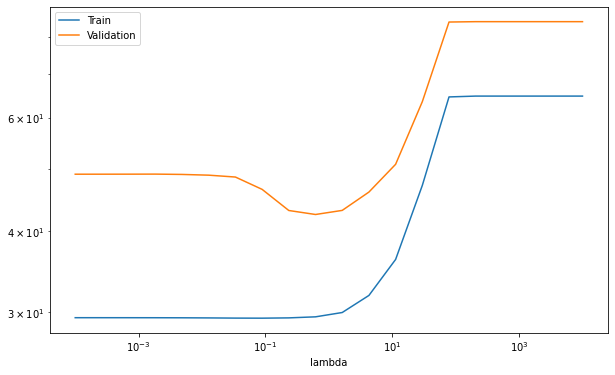

In [38]:
mse_score.plot(logx=True, logy=True, figsize=(10,6));

In [79]:
# Show which observations that go into train and validation sets
# ts_cv = TimeSeriesSplit(n_splits=15, test_size=1)
# for train_index, test_index in ts_cv.split(X_train):
#     print("TRAIN:", train_index, "TEST:", test_index)


In [30]:
# Using the defined pipeline to fit our training set
#gs_lasso.fit(X_train_new,y_train)
# And predicting using the LASSO regression model and the test data 
y_pred_lasso = gs_lasso.predict(X_test_new)

<ipython-input-49-1ca2e1d839fd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["pred"] = y_pred_lasso


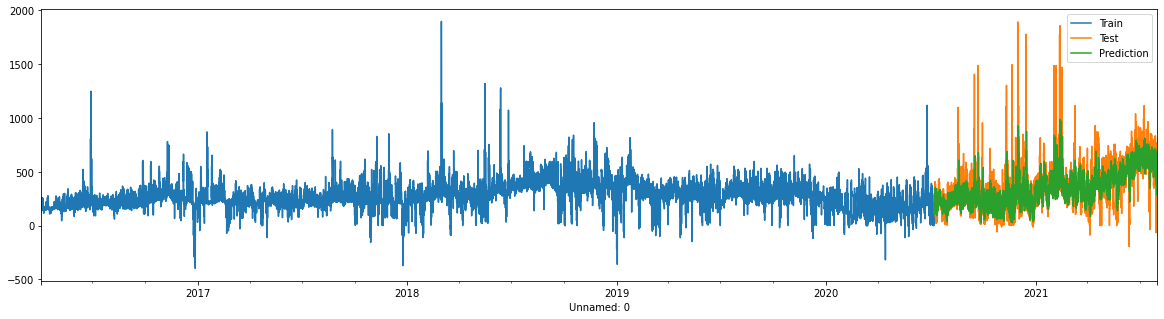

In [49]:
# Plot the actual values (train and test) and predicted valuesw
fig, ax = plt.subplots(figsize = (20,5))

df_train["DK2"].plot(ax=ax)
df_test["DK2"].plot(ax=ax)

df_test["pred"] = y_pred_lasso
df_test["pred"].plot(ax=ax)

ax.legend(["Train","Test","Prediction"]);
plt.show()

In [31]:
# Optimal lambda value from the grid search
print(f"Optimal lambda value in Lasso using grid search: {gs_lasso.best_params_}")

# Different scoring values
print_scores(y_test, y_pred_lasso)

Optimal lambda value in Lasso using grid search: {'lasso__alpha': 0.615848211066026}
R2 score: 0.6683178416583089
MSE score: 12995.79732276181
MAE score: 75.61216537959243
Median AE score: 55.45037214443789


<ipython-input-2-210cddad21fd>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100


MAPE score: inf
SMAPE score: 30.104814517596218


In [83]:
# Defining the final pipeline using the optimal lambda detected from the grid search 
finalpipe_lasso = Pipeline([
                       #('polynomial', PolynomialFeatures(degree = 2, include_bias=True, interaction_only=True)),
                       ('scale', StandardScaler()),
                       ('lasso', Lasso(alpha = gs_lasso.best_params_["lasso__alpha"]))
                       ])

# Fitting the training data and predicting on the test data
finalpipe_lasso.fit(X_train,y_train)
finalpipe_lasso.predict(X_test)

array([285.43590376, 218.19011579, 255.70559818, ..., 355.1842924 ,
       308.35461335, 347.58435728])

In [84]:
# Save coefficients to a dictionary
candy.drop("DK2", inplace = True, axis = 1)
d = {}
for i in range(len(candy.columns)):
    d[candy.columns[i]] = list(finalpipe_lasso.named_steps['lasso'].coef_)[i]


In [85]:
d

{'cloud_cover': -0.0,
 'temp_soil_max_past1h': 10.68283811937396,
 'wind_max_per10min_past1h': -0.0,
 'acc_precip': -0.0,
 'bright_sunshine': 0.0,
 'mean_pressure': 0.0,
 'mean_radiation': -3.7622708491285874,
 'mean_relative_hum': -0.0,
 'mean_temp': 0.0,
 'mean_wind_dir': -0.0,
 'mean_wind_speed': -1.0951927771393997,
 'temp_grass': -0.0,
 'DK1_CP': 24.62263432444711,
 'DK2_CP': 0.0,
 'DK1_PP': 17.875215537983777,
 'DK2_PP': 0.0,
 'DK1_WP': -26.518815691516316,
 'DK2_WP': -10.498977210998783,
 'hour_1': -0.0,
 'hour_2': -0.0,
 'hour_3': -0.0,
 'hour_4': -0.0,
 'hour_5': -0.0,
 'hour_6': -0.0,
 'hour_7': 0.0,
 'hour_8': 0.0,
 'hour_9': 0.0,
 'hour_10': 0.0,
 'hour_11': -0.0,
 'hour_12': -0.0,
 'hour_13': -0.0,
 'hour_14': -0.0,
 'hour_15': -0.0,
 'hour_16': -0.0,
 'hour_17': -0.0,
 'hour_18': 0.0,
 'hour_19': 0.0,
 'hour_20': 0.7054945908826136,
 'hour_21': 0.0,
 'hour_22': 0.0,
 'hour_23': 0.0,
 'weekday_1': 0.0,
 'weekday_2': 0.0,
 'weekday_3': -0.0,
 'weekday_4': 0.0,
 'weekday_5':

In [11]:
not_list = ['acc_precip',
'temp_grass',
'DK1 - DK2.L.24',
'DK - DE.L.24',
'cloud_cover',
'temp_soil_max_past1h',
'mean_relative_hum',
'DK1_CP',
'DK1_PP',
'DK1_WP',
'DK1 net exchange.L.24',
'DK2 net exchange.L.24',
'mean_wind_dir']

In [25]:
# Create arrays for X and y for both training and testing data set. 
y_train = df_train[["DK2"]].to_numpy()
y_test  = df_test[["DK2"]].to_numpy()

X_train_new = df_train[df_train.columns[~df_train.columns.isin(not_list)]].copy()
X_test_new  = df_test[df_test.columns[~df_test.columns.isin(not_list)]].copy()

X_train_new.drop('DK2', inplace=True, axis=1)
X_test_new.drop('DK2', inplace=True, axis=1)

X_train_new = X_train_new.to_numpy()
X_test_new  = X_test_new.to_numpy()

In [3]:
df_coef = pd.read_csv('ridge_coef.csv')

In [6]:
df_coef

,Unnamed: 0,cloud_cover,temp_soil_max_past1h,wind_max_per10min_past1h,acc_precip,bright_sunshine,mean_pressure,mean_radiation,mean_relative_hum,mean_temp,...,DK2.L.40,DK2.L.41,DK2.L.42,DK2.L.43,DK2.L.44,DK2.L.45,DK2.L.46,DK2.L.47,DK2.L.48,trend
0,0,0.162712,23.029324,-3.142979,-1.150559,2.620139,1.21171,-9.446996,-2.912223,-1.423339,...,0.051199,-0.720723,-0.748985,-0.277592,-0.065872,-0.373152,1.601708,1.495804,1.870339,15.164062
